<a href="https://colab.research.google.com/github/veryHapppy/study_ai/blob/main/Kaggle/spaceship_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna
!pip install catboost
from urllib.request import urlopen
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import optuna
from sklearn.model_selection import cross_val_score
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import VotingClassifier
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
def feature_engineering(df):

    spending_cols = ['RoomService', 'Spa', 'VRDeck']
    for col in spending_cols:
        df[col] = df[col].fillna(0.0)
    df['TotalSpending'] = df[spending_cols].sum(axis=1)

    df.loc[(df['CryoSleep'].isnull()) & (df['TotalSpending'] > 0), 'CryoSleep'] = False
    df['CryoSleep'] = df['CryoSleep'].fillna(df['TotalSpending'] == 0)

    df['VIP'] = df['VIP'].fillna(False)

    # 범주형은 최빈값으로
    for col in ['Destination']:
        df[col] = df[col].fillna(df[col].mode()[0])

    df['GroupId'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
    group_counts = df['GroupId'].value_counts()
    df['GroupSize'] = df['GroupId'].map(group_counts)

    df['HomePlanet'] = df.groupby('GroupId')['HomePlanet'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

    df['Cabin'] = df.groupby('GroupId')['Cabin'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

    df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])
    df['Cabin'] = df['Cabin'].fillna(df['Cabin'].mode()[0])

    df[['Deck', 'Cabin_num', 'Side']] = df['Cabin'].str.split('/', expand=True)

    df['CryoSleep'] = df['CryoSleep'].astype(int)
    df['VIP'] = df['VIP'].astype(int)
    df['IsSpender'] = (df['TotalSpending'] > 0).astype(int)

    df['Age'] = df['Age'].fillna(df.groupby(['HomePlanet', 'VIP', 'CryoSleep'])['Age'].transform('median'))

    df['Age'] = df['Age'].fillna(df['Age'].median())

    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 100], labels=['Child', 'Teen', 'Adult'])
    df['Cabin_num'] = df['Cabin_num'].astype(int)
    df['Cabin_pos'] = df.groupby('Deck')['Cabin_num'].transform(lambda x: (x - x.min()) / (x.max() - x.min() + 1))

    df['Surname'] = df['Name'].str.split().str[-1].fillna('Unknown')
    surname_counts = df['Surname'].value_counts()
    surname_counts['Unknown'] = 1
    df['FamilySize'] = df['Surname'].map(surname_counts)
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    return df

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csv/spaceship_titanic_train.csv')

data['Transported_int'] = data['Transported'].astype(int)

data = feature_engineering(data)

# HomePlanet Deck Side Destination

/tmp/ipython-input-2862300101.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep'] = df['CryoSleep'].fillna(df['TotalSpending'] == 0)
/tmp/ipython-input-2862300101.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False)
/tmp/ipython-input-2862300101.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['HomePlanet'] = df.groupby('GroupId')['HomePlanet'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill

In [ ]:
data = data[data['TotalSpending'] < 15000].copy()

# 2. 로그 변환 (Log1p) 적용
# log(1+x)를 사용하는 이유는 x가 0일 때 log(0)인 무한대(-inf)가 되는 것을 방지하기 위함입니다.
data['TotalSpending_log'] = np.log1p(data['TotalSpending'])

features = ['HomePlanet', 'Deck', 'Side', 'Destination', 'VIP', 'CryoSleep', 'GroupSize', 'TotalSpending_log', 'IsSpender', 'AgeGroup', 'Cabin_pos', 'Age','FamilySize', 'IsAlone']

X = data[features]
y = data['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = ['GroupSize', 'TotalSpending_log', 'Age','FamilySize', 'Cabin_pos']
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # 빈칸은 중앙값으로
    ('scaler', StandardScaler())                   # 표준화 스케일링
])

# 3. 범주형 데이터 전처리 공정 (항구, 성별)
cat_features = ['HomePlanet', 'Deck', 'Side', 'Destination', 'AgeGroup']
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # 빈칸은 최빈값으로
    ('onehot', OneHotEncoder(handle_unknown='ignore'))    # 원-핫 인코딩
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features),
        ('pass', 'passthrough', ['VIP', 'CryoSleep', 'IsAlone', 'IsSpender'])
    ])


In [ ]:
def objective(trial):
    # 1. 각 모델별 다이얼 범위 설정
    # XGBoost 파라미터
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n', 50, 200),
        'max_depth': trial.suggest_int('xgb_depth', 3, 7),
        'colsample_bytree': trial.suggest_float('xgb_colsample', 0.6, 0.8),
        'reg_alpha': trial.suggest_float('xgb_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('xgb_lambda', 1e-3, 10.0, log=True),
        'learning_rate': trial.suggest_float('xgb_lr', 0.01, 0.1),
    }

    # LightGBM 파라미터
    lgbm_params = {
        'n_estimators': trial.suggest_int('lgbm_n', 50, 200),
        'num_leaves': trial.suggest_int('lgbm_leaves', 15, 50),
        'learning_rate': trial.suggest_float('lgbm_lr', 0.01, 0.1),
        'verbose': -1
    }

    # CatBoost 파라미터
    cat_params = {
        'iterations': trial.suggest_int('cat_iter', 50, 200),
        'depth': trial.suggest_int('cat_depth', 3, 7),
        'learning_rate': trial.suggest_float('cat_lr', 0.01, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
        'verbose': 0
    }

    # 2. 모델간 가중치(Weight) 설정
    w_xgb = trial.suggest_float('w_xgb', 0.5, 3.0) # 0.5~2.0 사이의 실수
    w_lgbm = trial.suggest_float('w_lgbm', 0.5, 3.0)
    w_cat = trial.suggest_float('w_cat', 0.5, 3.0)

    # 3. 모델 객체 생성
    xgb = XGBClassifier(**xgb_params, random_state=42)
    lgbm = LGBMClassifier(**lgbm_params, random_state=42)
    cat = CatBoostClassifier(**cat_params, random_state=42)

    # 4. 앙상블 모델 구축
    voting_model = VotingClassifier(
        estimators=[('xgb', xgb), ('lgbm', lgbm), ('cat', cat)],
        voting='soft',
        weights=[w_xgb, w_lgbm, w_cat]
    )

    # 5. 파이프라인 연결 및 평가
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('ensemble', voting_model)
    ])

    # 교차 검증으로 점수 측정 (과적합 방지를 위해 5-Fold 사용)
    score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy').mean()

    return score

# 6. 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3) # 시도 횟수

print(f"최고 정확도: {study.best_value:.4f}")
for i in study.best_params:
    print(f"{i}: {study.best_params[i]}")

[I 2025-12-22 11:31:08,694] A new study created in memory with name: no-name-de7e0008-9262-4936-9280-63ff260b71bf
[I 2025-12-22 11:31:16,735] Trial 0 finished with value: 0.7937165611514079 and parameters: {'xgb_n': 96, 'xgb_depth': 3, 'xgb_colsample': 0.7102997624217797, 'xgb_alpha': 7.2655786171926575, 'xgb_lambda': 7.479688776398313, 'xgb_lr': 0.01213715322091136, 'lgbm_n': 161, 'lgbm_leaves': 46, 'lgbm_lr': 0.06123117919971282, 'cat_iter': 58, 'cat_depth': 5, 'cat_lr': 0.0429955164931545, 'l2_leaf_reg': 9.857532132132691, 'random_strength': 1.0732553463298833, 'w_xgb': 0.7153414804368886, 'w_lgbm': 1.9273237798208591, 'w_cat': 1.001522771503754}. Best is trial 0 with value: 0.7937165611514079.
[I 2025-12-22 11:31:31,094] Trial 1 finished with value: 0.7957344755438001 and parameters: {'xgb_n': 132, 'xgb_depth': 3, 'xgb_colsample': 0.6106879612685057, 'xgb_alpha': 0.04950788434456673, 'xgb_lambda': 0.40856235473683533, 'xgb_lr': 0.06627118911402212, 'lgbm_n': 144, 'lgbm_leaves': 46,

최고 정확도: 0.7957
xgb_n: 132
xgb_depth: 3
xgb_colsample: 0.6106879612685057
xgb_alpha: 0.04950788434456673
xgb_lambda: 0.40856235473683533
xgb_lr: 0.06627118911402212
lgbm_n: 144
lgbm_leaves: 46
lgbm_lr: 0.058892724827016345
cat_iter: 195
cat_depth: 5
cat_lr: 0.0672038128418729
l2_leaf_reg: 2.9864778091284103
random_strength: 7.184838503524317
w_xgb: 2.391312426295825
w_lgbm: 1.1116739984964112
w_cat: 1.3544646999817005


In [ ]:
best = study.best_params

xgb_final = XGBClassifier(
    n_estimators=best['xgb_n'],
    max_depth=best['xgb_depth'],
    learning_rate=best['xgb_lr'],
    colsample_bytree=best['xgb_colsample'],
    reg_alpha=best['xgb_alpha'],
    reg_lambda=best['xgb_lambda'],
    random_state=42
)

lgbm_final = LGBMClassifier(
    n_estimators=best['lgbm_n'],
    num_leaves=best['lgbm_leaves'],
    learning_rate=best['lgbm_lr'],
    random_state=42,
    verbose=-1
)

cat_final = CatBoostClassifier(
    iterations=best['cat_iter'],
    depth=best['cat_depth'],
    learning_rate=best['cat_lr'],
    l2_leaf_reg=best['l2_leaf_reg'],
    random_strength=best['random_strength'],
    random_state=42,
    verbose=0
)

# voting 방식
voting_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_final),
        ('lgbm', lgbm_final),
        ('cat', cat_final)
    ],
    voting='soft',
    weights=[best['w_xgb'], best['w_lgbm'], best['w_cat']]
)

#stacking 방식
stacking_model = StackingClassifier(
    estimators=[
        ('xgb', xgb_final),
        ('lgbm', lgbm_final),
        ('cat', cat_final)
    ],
    final_estimator=LogisticRegression(),
    cv=5
)

final_voting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', voting_model)
])
final_stacking_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', stacking_model)
])

final_voting_pipeline.fit(X_train, y_train)
final_stacking_pipeline.fit(X_train, y_train)

print(f"voting 검증 점수: {final_voting_pipeline.score(X_test, y_test):.4f}")
print(f"stacking 검증 점수: {final_stacking_pipeline.score(X_test, y_test):.4f}")

# 6. 모델 저장
joblib.dump(final_voting_pipeline, 'spaceship_titanic_voting_best.pkl')
joblib.dump(final_stacking_pipeline, 'spaceship_titanic_stacking_best.pkl')
print("저장되었습니다")


voting 검증 점수: 0.7988
stacking 검증 점수: 0.8035
저장되었습니다


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/csv/spaceship_titanic_test.csv')
test_data = feature_engineering(test)
test_data['TotalSpending_log'] = np.log1p(test_data['TotalSpending'])

features = ['HomePlanet', 'Deck', 'Side', 'Destination', 'VIP', 'CryoSleep', 'GroupSize', 'TotalSpending_log', 'IsSpender', 'AgeGroup', 'Cabin_pos', 'Age','FamilySize', 'IsAlone']

loaded_model = joblib.load('spaceship_titanic_stacking_best.pkl')
test_preds = loaded_model.predict(test_data[features])
test_preds = test_preds.astype(bool)
# 8. 제출 파일 생성
submission = pd.DataFrame({
    'PassengerId': test['PassengerId'],
    'Transported': test_preds
})

submission.to_csv('submission.csv', index=False)
print("제출 파일 'submission.csv'가 저장되었습니다!")

/tmp/ipython-input-2862300101.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep'] = df['CryoSleep'].fillna(df['TotalSpending'] == 0)
/tmp/ipython-input-2862300101.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False)
/tmp/ipython-input-2862300101.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['HomePlanet'] = df.groupby('GroupId')['HomePlanet'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill

제출 파일 'submission.csv'가 저장되었습니다!


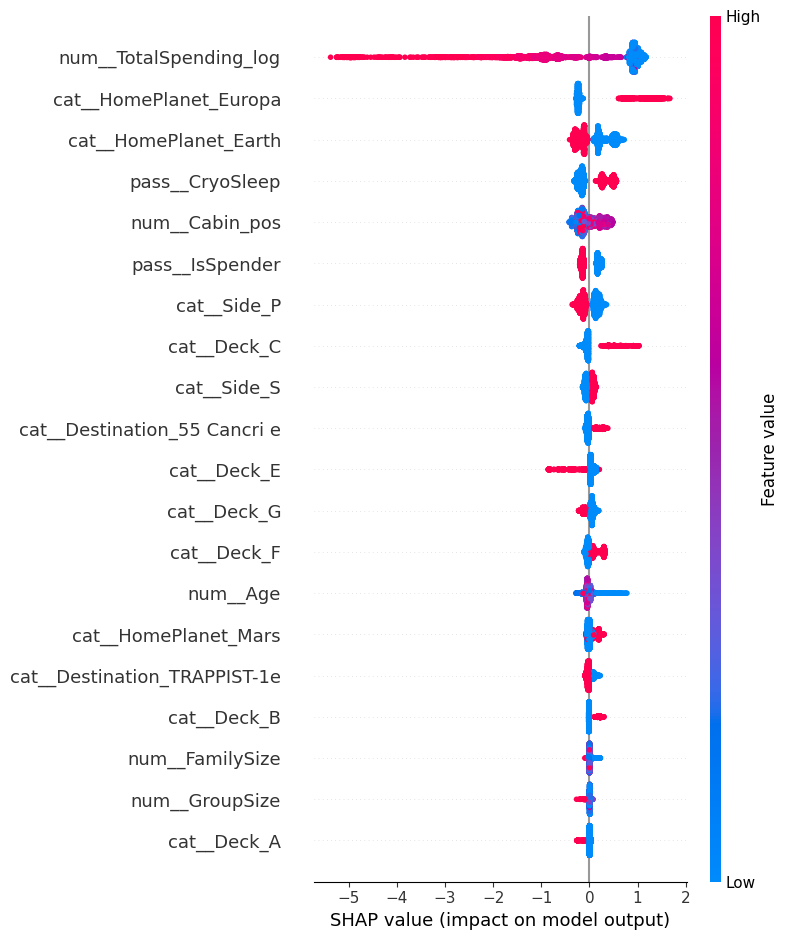

In [ ]:
import shap

voting_model = final_voting_pipeline.named_steps['model']
xgb = voting_model.named_estimators_['xgb']

# 전처리기를 거친 데이터를 미리 준비해야 합니다.
X_transformed = final_stacking_pipeline.named_steps['preprocessor'].transform(test_data)
feature_names = final_stacking_pipeline.named_steps['preprocessor'].get_feature_names_out()

# 2. Explainer 생성
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_transformed)

# 3. 요약 그래프 (어떤 피처가 전체적으로 중요한가?)
shap.summary_plot(shap_values, X_transformed, feature_names=feature_names)

In [ ]:
import shap
import matplotlib.pyplot as plt

def plot_shap_summary(model, X_transformed, feature_names, model_name):
    """
    SHAP Value를 계산하고 요약 그래프를 시각화하는 함수
    """
    # 1. Explainer 설정
    # 트리 기반 모델(XGB, LGBM, CatBoost, RandomForest)은 TreeExplainer가 가장 빠르고 정확합니다.
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_transformed)
    except:
        # 트리 기반이 아니거나 오류 발생 시 일반적인 KernelExplainer 사용 (속도는 더 느림)
        explainer = shap.Explainer(model, X_transformed)
        shap_values = explainer(X_transformed).values

    # 2. 결과가 리스트 형태인 경우 (이진 분류에서 0, 1 클래스 중 1번 클래스 선택)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    # 3. 시각화
    plt.figure(figsize=(10, 8))
    plt.title(f"SHAP Summary Plot - {model_name}")

    # feature_names를 인자로 넘겨주어 그래프에 변수명이 나오게 함
    shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, show=False)

    plt.tight_layout()
    plt.show()

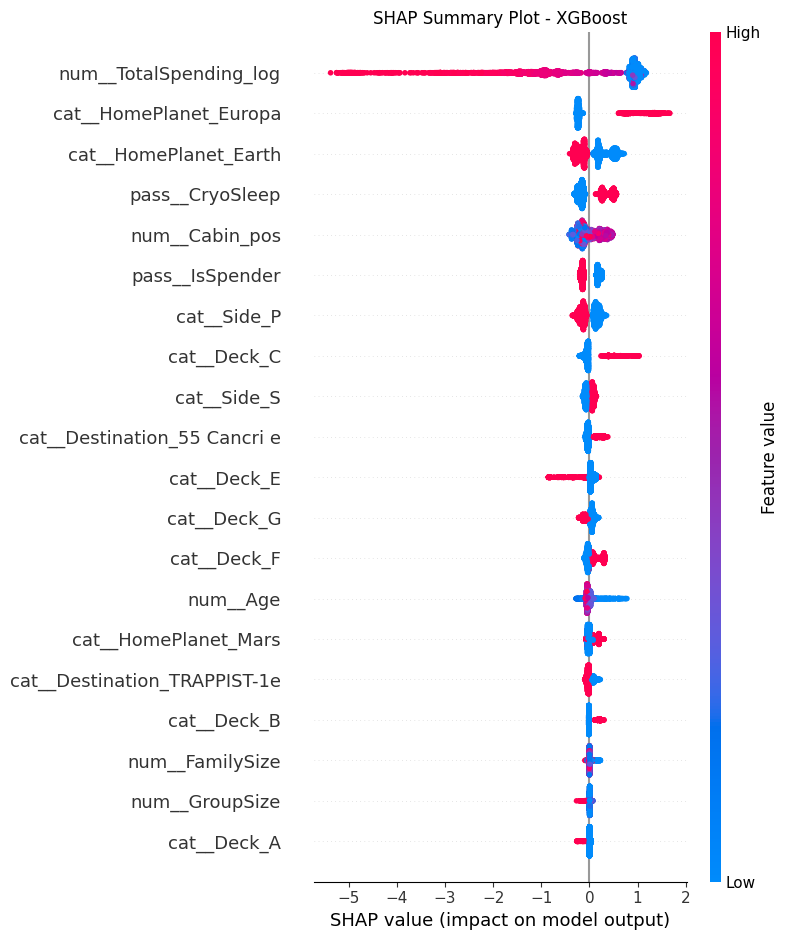

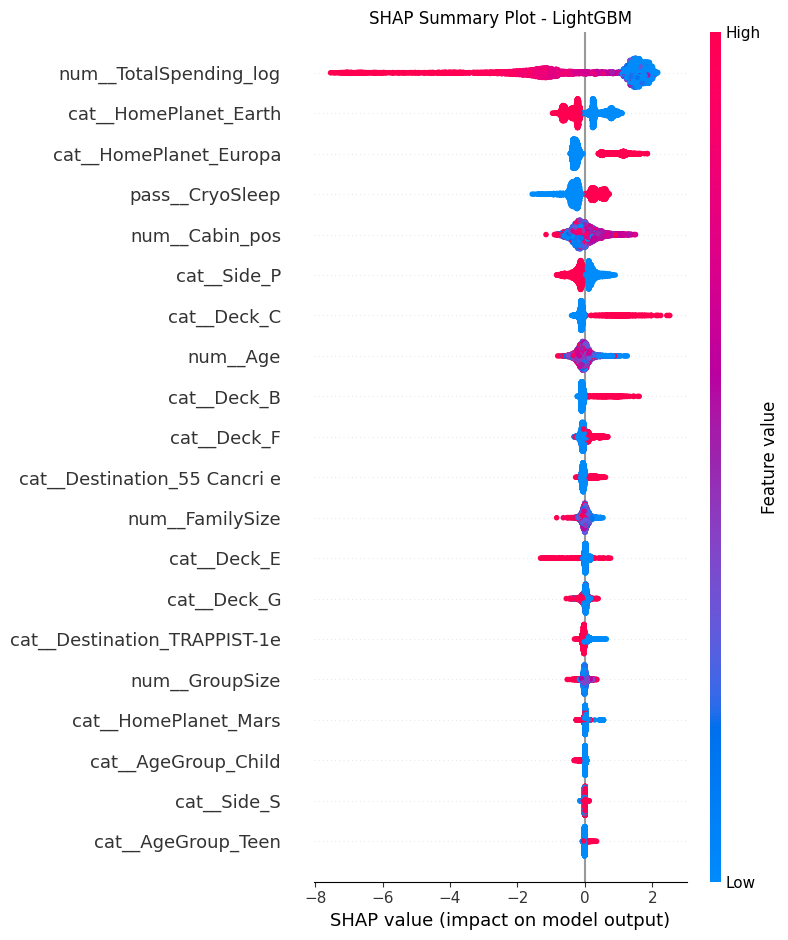

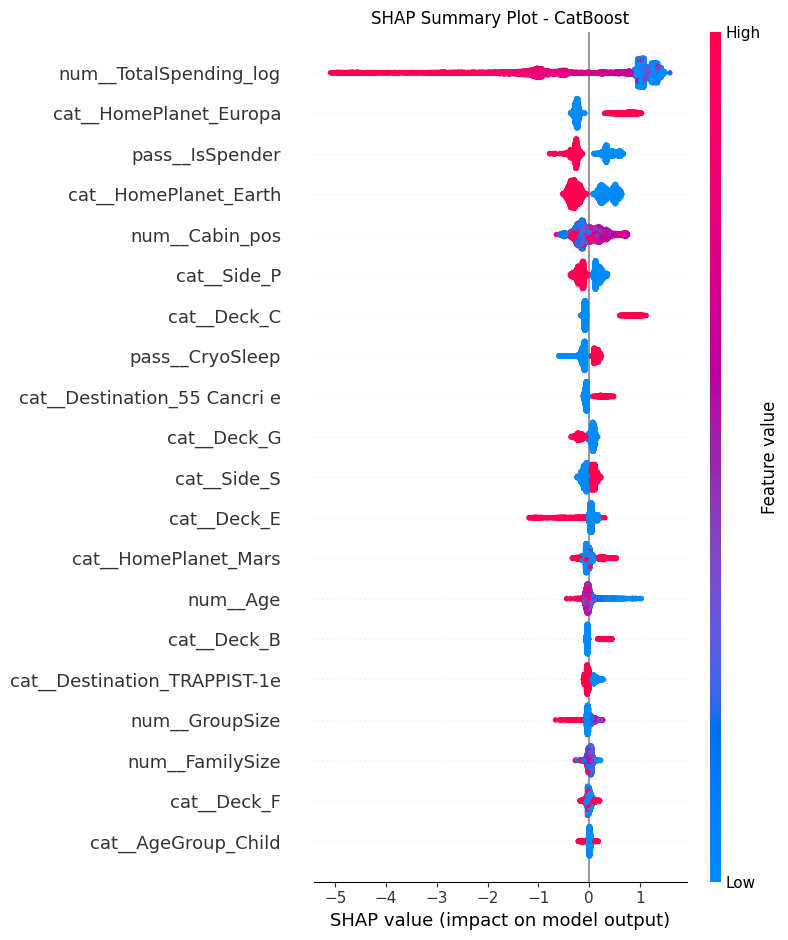

In [ ]:
# (One-Hot Encoding 때문에 컬럼 수가 늘어났을 수 있으므로 전처리기에서 추출해야 함)
feature_names = final_voting_pipeline.named_steps['preprocessor'].get_feature_names_out()

# 앙상블 내부의 각 모델 중요도 확인
voting_model = final_voting_pipeline.named_steps['model']


plot_shap_summary(voting_model.named_estimators_['xgb'],X_transformed , feature_names, "XGBoost")

plot_shap_summary(voting_model.named_estimators_['lgbm'],X_transformed, feature_names, "LightGBM")

plot_shap_summary(voting_model.named_estimators_['cat'], X_transformed, feature_names, "CatBoost")